In [11]:
import serial
from scipy.optimize import curve_fit
from scipy.signal import lsim, TransferFunction
import matplotlib.pyplot as plt
import time
import numpy as np

In [39]:
port = 'COM4'
mult = 1000

def get_serial_data(f0, f1, chirp_pwm):
    data_names = []
    data_recv = {}
    with serial.Serial(port, 115200, timeout=3) as ser:
        params = f"{f0},{f1},{chirp_pwm}\n"
        print("Sending: ", params)
        time.sleep(5)
        ser.write(params.encode())
        time.sleep(0.1)
        
        print("Reading", end='')
        read_first_data = False
        count = 0

        ser.flush()        
        while True:
            data = ser.readline().decode('utf-8').strip()
            if data:
                split_data = data.split(';')
                if not read_first_data:
                    data_names = split_data
                    for i in range(len(data_names)):
                        data_recv[data_names[i]] = []
                    read_first_data = True
                    continue
                numbers = [float(num) for num in split_data]
                for i in range(len(data_names)):
                    data_recv[data_names[i]].append(numbers[i]/mult)
                
                if count % 100 == 0:
                    print('.', end='')
                count += 1
            else:
                if read_first_data:
                    break
        print()
    return data_names, data_recv

# Experiment 1

In [40]:
ret = get_serial_data(0.1, 5, 0.50)

data_names = ret[0]
data = ret[1]
print(data_names)

Sending:  0.1,5,0.5

Reading............................................................
['t', 'u', 'theta_1']


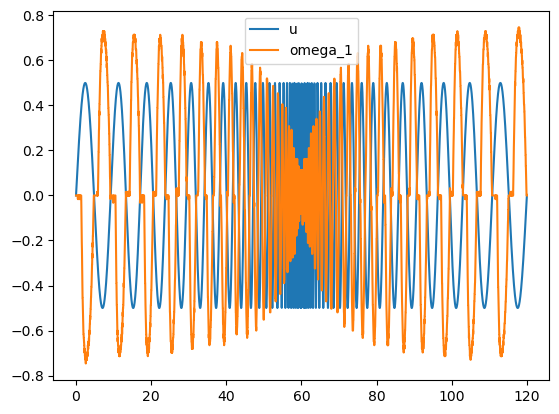

In [41]:
data["omega_1"] = np.gradient(np.array(data["theta_1"])).tolist()

plt.plot(data["t"], data["u"], label="u")
plt.plot(data["t"], data["omega_1"], label="omega_1")
plt.legend()
plt.show()

ts:  0.020011597199066356
K: -1.3422184691389192, tau: 0.31961448467721415


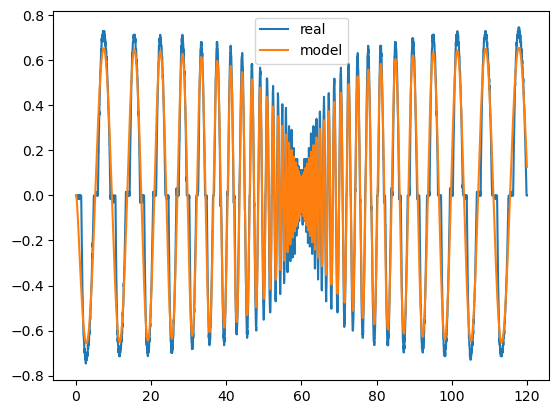

In [42]:
t = data["t"]
u = data["u"]
omega_1 = data["omega_1"]

ts = np.mean(np.gradient(t))
print("ts: ", ts)

t_ts = np.linspace(0, (len(t) - 1)*ts, len(t))

def simulate_first_order_system(time, K, tau, u):
    num = [K]
    den = [tau, 1]

    system = TransferFunction(num, den)
    _, y_out, _ = lsim(system, U=u, T=time)

    return y_out

params, covariance = curve_fit(lambda time, K, tau: simulate_first_order_system(time, K, tau, u), t_ts, omega_1, p0=[1,1])

K_est, tau_est = params

print(f"K: {K_est}, tau: {tau_est}")

plt.plot(t, omega_1, label="real")
plt.plot(t_ts, simulate_first_order_system(t_ts, K_est, tau_est, u), label="model")
plt.legend()
plt.show()

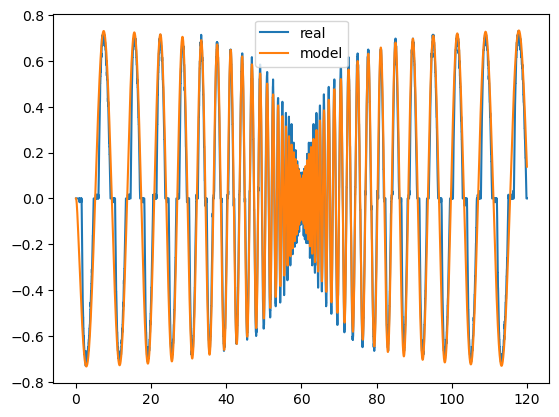

In [42]:
K_est = K_est * 1.15 # correção manual 

plt.plot(t, omega_1, label="real")
plt.plot(t_ts, simulate_first_order_system(t_ts, K_est, tau_est, u), label="model")
plt.legend()
plt.show()

# Experiment 2

In [ ]:
ret = get_serial_data(0.1, 5, 0.50)

data_names = ret[0]
data = ret[1]
print(data_names)

In [ ]:
data["omega_1"] = np.gradient(np.array(data["theta_1"])).tolist()

plt.plot(data["t"], data["u"], label="u")
plt.plot(data["t"], data["omega_1"], label="omega_1")
plt.legend()
plt.show()